In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial import Voronoi
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from itertools import permutations

import py4DSTEM
from py4DSTEM.process.utils import get_maxima_2D
from py4DSTEM.file.datastructure import PointListArray

from py4DSTEM.process.classification import get_braggpeak_labels_by_scan_position
from py4DSTEM.process.utils import get_voronoi_vertices

In [3]:
#fp = "/home/ben/Data/20190128_ClassificationData/EASY_binDiffraction4.h5"
fp = "/Users/Ben/Desktop/EASY_binDiffraction4_no_datacube.h5"
browser = py4DSTEM.file.readwrite.FileBrowser(fp)
ave_im = browser.get_dataobject('average_image').data2D
deconvolution = browser.get_dataobject('deconvolution').data2D
braggpeaks = browser.get_dataobject('Bragg_peaks')
browser.close()

Q_Nx, Q_Ny = deconvolution.shape
R_Nx,R_Ny = ave_im.shape

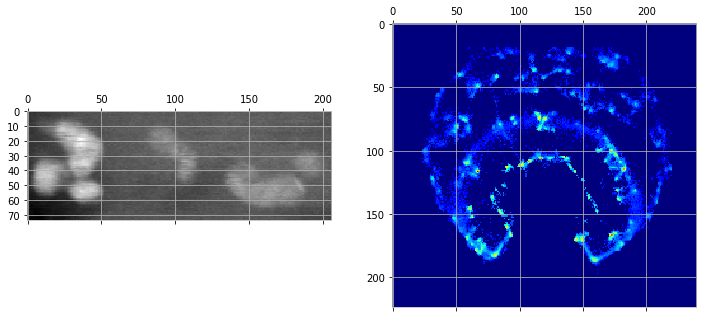

In [4]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(ave_im)
ax2.matshow(deconvolution**0.2,cmap='jet')
plt.show()

#### Get bragg peaks sets at each scan position

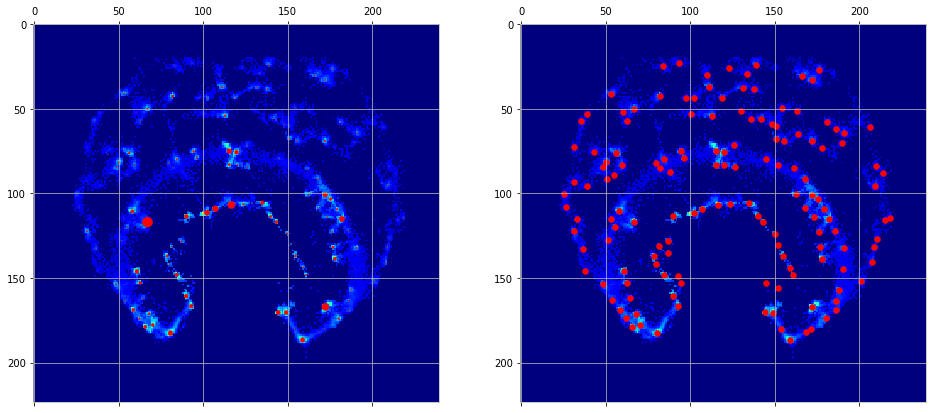

In [5]:
# Get deconvolution maxima

sigma = 1
edgeBoundary = 0
minSpacing = 0
minRelativeIntensity = 0.0005
relativeToPeak = 0
maxNumPeaks = 0
subpixel = True

power = 0.25
scale = 100

maxima_x, maxima_y, maxima_int = get_maxima_2D(deconvolution, sigma=sigma, edgeBoundary=edgeBoundary,
                                               minSpacing=minSpacing, minRelativeIntensity=minRelativeIntensity,
                                               relativeToPeak=relativeToPeak, maxNumPeaks=maxNumPeaks,
                                               subpixel=subpixel)

# Show
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution**power,cmap='jet')
ax1.scatter(maxima_y,maxima_x,color='r',
            s=scale*maxima_int/np.max(maxima_int))
ax2.matshow(deconvolution**power,cmap='jet')
ax2.scatter(maxima_y,maxima_x,color='r')
plt.show()

In [6]:
# Get the sets of Bragg peaks present at each scan position

braggpeak_labels = get_braggpeak_labels_by_scan_position(braggpeaks,maxima_x,maxima_y)

#### Show Voronoi diagram

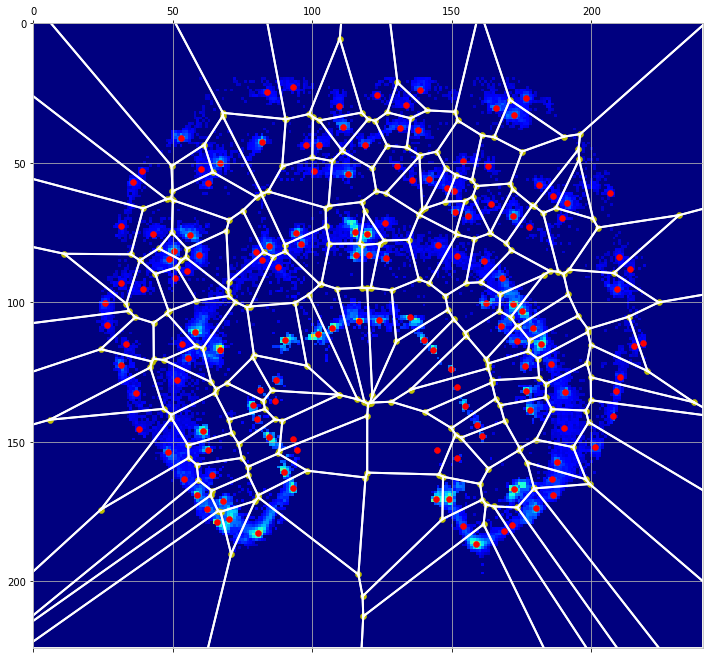

In [7]:
# Make a Voronoi diagram
points = np.vstack((maxima_x,maxima_y)).T
voronoi = Voronoi(points)

# Get vertices
vertices = get_voronoi_vertices(voronoi, Q_Nx, Q_Ny)

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(deconvolution**0.25,cmap='jet')
ax.scatter(voronoi.points[:,1],voronoi.points[:,0],color='r')
ax.scatter(voronoi.vertices[:,1],voronoi.vertices[:,0],color='y')
for region in range(len(vertices)):
    vertices_curr = vertices[region]
    for i in range(len(vertices_curr)):
        x0,y0 = vertices_curr[i,:]
        x1,y1 = vertices_curr[(i+1)%len(vertices_curr),:]
        ax.plot((y0,y1),(x0,x1),'w')        
ax.set_xlim([0,deconvolution.shape[1]])
ax.set_ylim([0,deconvolution.shape[0]])
plt.gca().invert_yaxis()
plt.show()

#### Get initial classes

In [135]:
# Combine

N_BP_thresh = 0.1
max_iterations = 200
thresh = 0.3

# Get the three-point function
threepoint_function = np.zeros((N,N,N))
for Rx in range(R_Nx):
    for Ry in range(R_Ny):
        s = braggpeak_labels[Rx][Ry]
        perms = permutations(s,3)
        for perm in perms:
            threepoint_function[perm[0],perm[1],perm[2]] += 1
threepoint_function /= R_Nx*R_Ny

# Get the BP triplet maximizing three-point function
# For each such triplet, find how correlated each other peak is; if the highest correlation is > thresh, add, that peak
# Repeat until the highest correlation is < thresh, adding peaks successively to the class
# Zero the slices of the 3-point function corresponding to these BPs
# Repeat until no peaks remain
class_BP_sets = []
unused_BPs = np.ones(N,dtype=bool)
iteration = 0
seed_new_class = True
while seed_new_class:
    ind1,ind2,ind3 = np.unravel_index(np.argmax(threepoint_function),(N,N,N))
    class_BP_set = set([ind1,ind2,ind3])
    grow_class = True
    while grow_class:
        frequencies = np.zeros(N)
        N_elements = 0
        for Rx in range(R_Nx):
            for Ry in range(R_Ny):
                s = braggpeak_labels[Rx][Ry]
                if class_BP_set.issubset(s):
                    N_elements += 1
                    for i in s:
                        frequencies[i] += 1
        frequencies /= N_elements
        for i in class_BP_set:
            frequencies[i] = 0
        ind_new = np.argmax(frequencies)
        if frequencies[ind_new] > thresh:
            class_BP_set.add(ind_new)
        else:
            grow_class = False
    for s in class_BP_sets:
        if len(s) == len(s.union(class_BP_set)):
            seed_new_class = False
    class_BP_sets.append(class_BP_set)
    if seed_new_class is False:
        class_BP_sets.pop()
    iteration += 1
    N_unused_BPs = np.sum(unused_BPs)
    if iteration > max_iterations or N_unused_BPs < N_BP_thresh*N:
        seed_new_class = False
    for index in class_BP_set:
        threepoint_function[index,:,:] = 0
        threepoint_function[:,index,:] = 0
        threepoint_function[:,:,index] = 0
        unused_BPs[index] = 0
print('Done.')

Done.


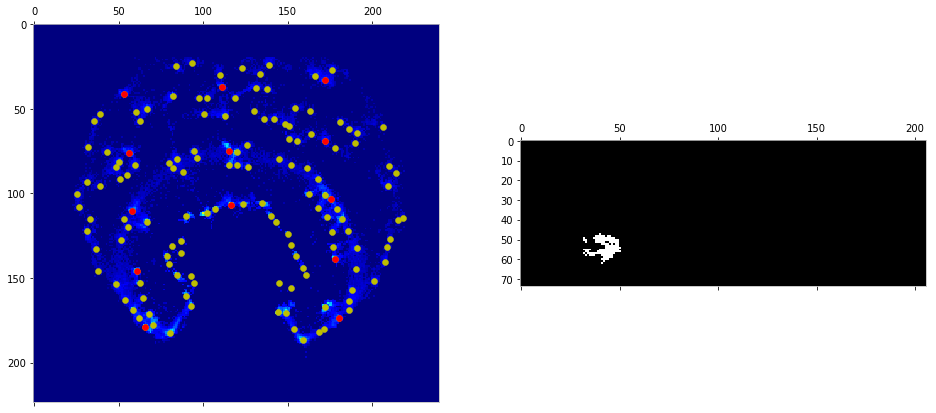

In [136]:
index = 1

class_BP_set = class_BP_sets[index]
class_mask = np.zeros((R_Nx,R_Ny),dtype=bool)
for Rx in range(R_Nx):
    for Ry in range(R_Ny):
        s = braggpeak_labels[Rx][Ry]
        if len(s)==len(s.union(class_BP_set)):
            class_mask[Rx,Ry] = True

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution**power,cmap='jet')
ax1.scatter(maxima_y,maxima_x,color='y')
for i in class_BP_set:
    ax1.scatter(maxima_y[i],maxima_x[i],color='r')
ax1.grid(False)
ax2.matshow(class_mask)
ax2.grid(False)
plt.show()

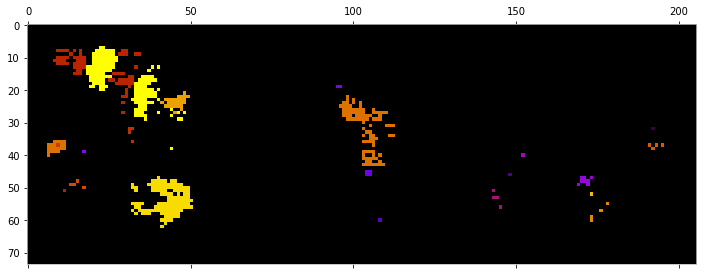

In [108]:
class_labels_init = np.zeros((R_Nx,R_Ny),dtype=int)

for i in range(len(class_BP_sets)):
    class_BP_set = class_BP_sets[i]
    for Rx in range(R_Nx):
        for Ry in range(R_Ny):
            s = braggpeak_labels[Rx][Ry]
            if len(s)==len(s.union(class_BP_set)):
                class_labels_init[Rx,Ry] = i+1

class_labels_init = -1*class_labels_init + np.max(class_labels_init) + 1
class_labels_init = np.where(class_labels_init==np.max(class_labels_init),0,class_labels_init)
fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(class_labels_init,cmap='gnuplot')
ax.grid(False)
plt.show()

#### Visualize process

In [124]:
# Combine

N_BP_thresh = 0.1
max_iterations = 200
thresh = 0.3

# Get the three-point function
threepoint_function = np.zeros((N,N,N))
for Rx in range(R_Nx):
    for Ry in range(R_Ny):
        s = braggpeak_labels[Rx][Ry]
        perms = permutations(s,3)
        for perm in perms:
            threepoint_function[perm[0],perm[1],perm[2]] += 1
threepoint_function /= R_Nx*R_Ny

# Get the BP triplet maximizing three-point function
# For each such triplet, find how correlated each other peak is; if the highest correlation is > thresh, add, that peak
# Repeat until the highest correlation is < thresh, adding peaks successively to the class
# Zero the slices of the 3-point function corresponding to these BPs
# Repeat until no peaks remain
class_BP_sets = []
class_BP_frequencies = []
unused_BPs = np.ones(N,dtype=bool)
iteration = 0
seed_new_class = True
while seed_new_class:
    ind1,ind2,ind3 = np.unravel_index(np.argmax(threepoint_function),(N,N,N))
    class_BP_set = [ind1,ind2,ind3]
    BP_frequencies = []
    grow_class = True
    while grow_class:
        frequencies = np.zeros(N)
        N_elements = 0
        for Rx in range(R_Nx):
            for Ry in range(R_Ny):
                s = braggpeak_labels[Rx][Ry]
                if set(class_BP_set).issubset(s):
                    N_elements += 1
                    for i in s:
                        frequencies[i] += 1
        frequencies /= N_elements
        for i in class_BP_set:
            frequencies[i] = 0
        ind_new = np.argmax(frequencies)
        BP_frequencies.append(frequencies[ind_new])
        if frequencies[ind_new] > thresh:
            if ind_new not in class_BP_set:
                class_BP_set.append(ind_new)
        else:
            if ind_new not in class_BP_set:
                class_BP_set.append(ind_new)
            grow_class = False
    for s in class_BP_sets:
        s = set(s)
        if len(s) == len(s.union(set(class_BP_set))):
            seed_new_class = False
    class_BP_sets.append(class_BP_set)
    class_BP_frequencies.append(BP_frequencies)
    if seed_new_class is False:
        class_BP_sets.pop()
    iteration += 1
    N_unused_BPs = np.sum(unused_BPs)
    if iteration > max_iterations or N_unused_BPs < N_BP_thresh*N:
        seed_new_class = False
    for index in class_BP_set:
        threepoint_function[index,:,:] = 0
        threepoint_function[:,index,:] = 0
        threepoint_function[:,:,index] = 0
        unused_BPs[index] = 0
print('Done.')

********** 0 **********
********** 1 **********
********** 2 **********
********** 3 **********
********** 4 **********
********** 5 **********
********** 6 **********
********** 7 **********
********** 8 **********
********** 9 **********
********** 10 **********
********** 11 **********
********** 12 **********
********** 13 **********
********** 14 **********
********** 15 **********
********** 16 **********
********** 17 **********
********** 18 **********
********** 19 **********
Done.


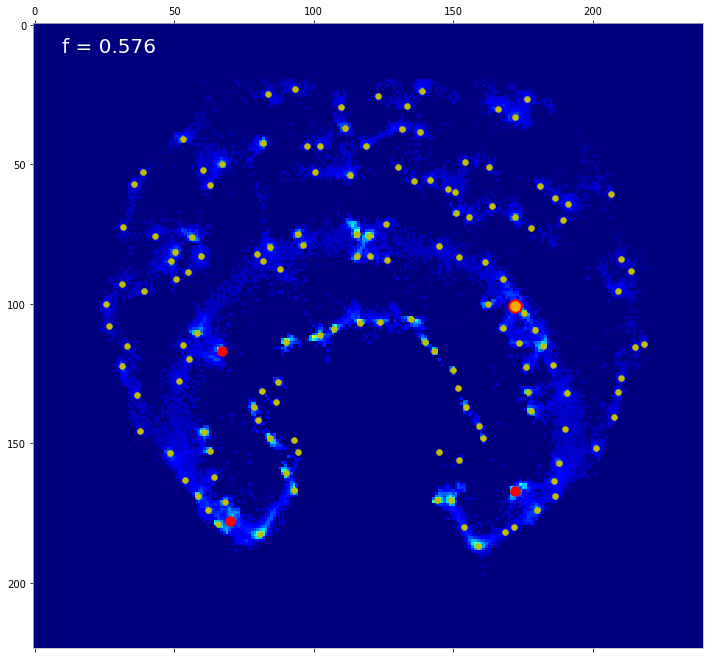

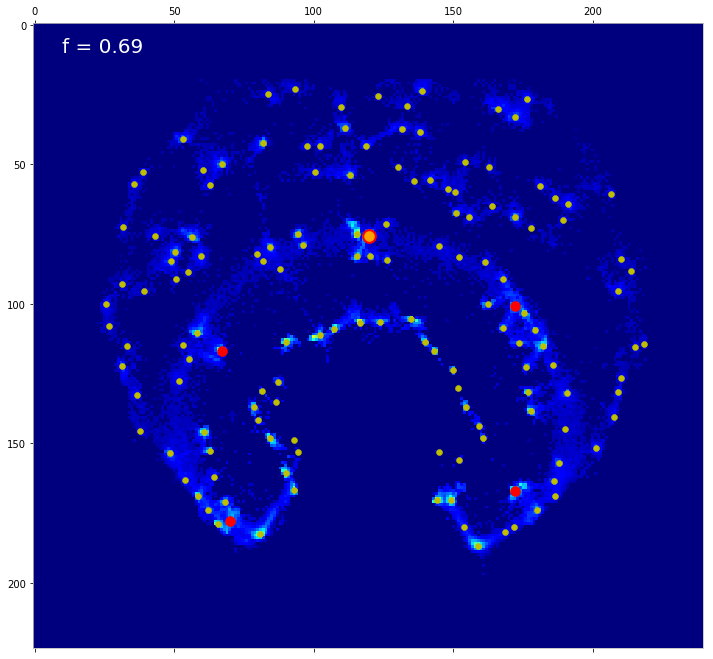

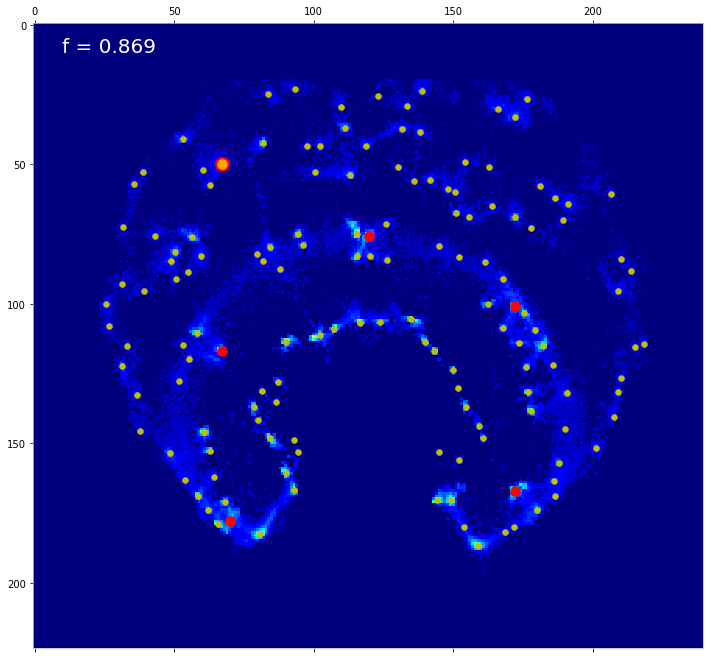

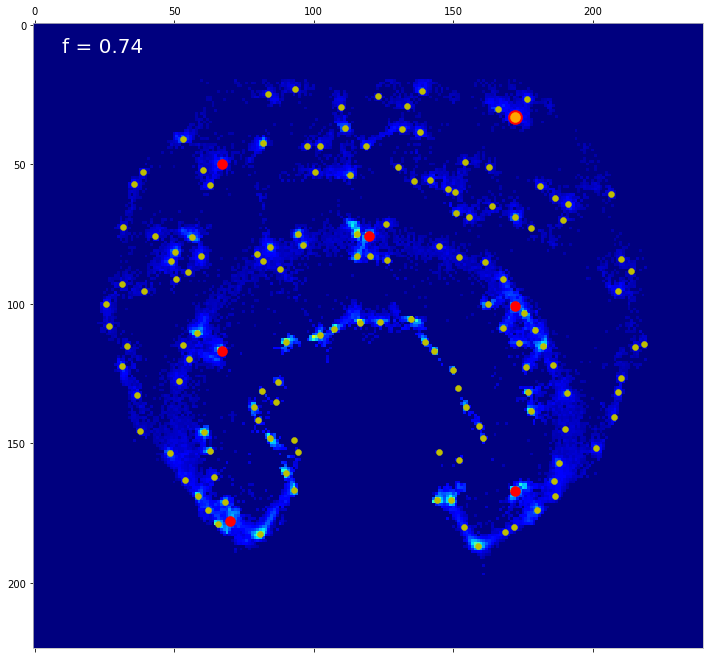

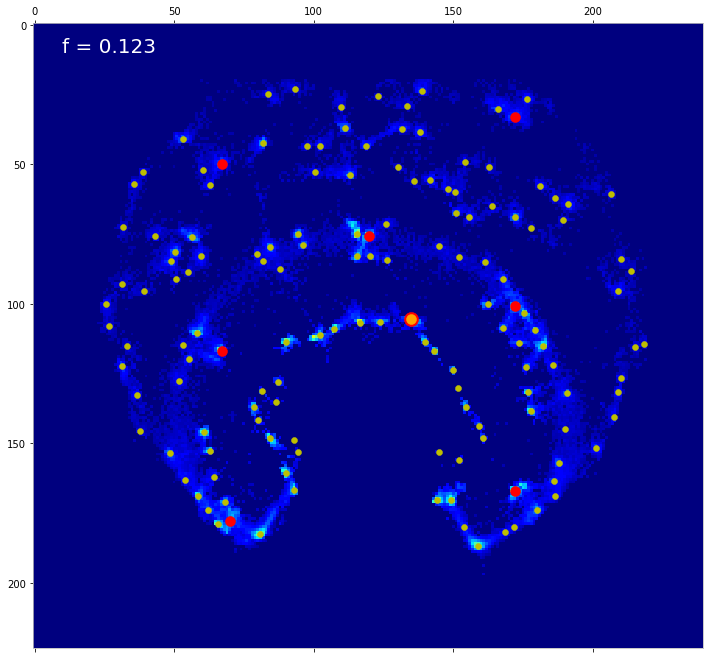

In [130]:
i_bp_set = 0

class_BP_set = class_BP_sets[i_bp_set]
BP_frequencies = class_BP_frequencies[i_bp_set]

for n in range(3,len(class_BP_set)):
    fig,ax = plt.subplots(figsize=(12,12))
    ax.matshow(deconvolution**power,cmap='jet')
    ax.scatter(maxima_y,maxima_x,color='y')
    for ind in range(n):
        i = class_BP_set[ind]
        ax.scatter(maxima_y[i],maxima_x[i],color='r',s=100)
    i = class_BP_set[n]
    ax.scatter(maxima_y[i],maxima_x[i],color='r',s=200)
    ax.scatter(maxima_y[i],maxima_x[i],color='orange',s=100)
    ax.grid(False)
    ax.text(10,10,'f = {:.3}'.format(BP_frequencies[n-3]),color='w',size=20)
    plt.show()

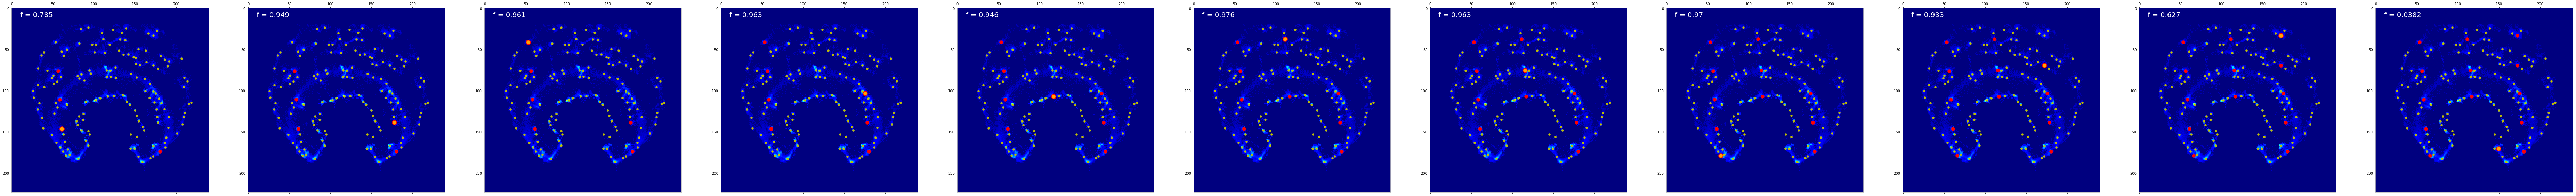

In [133]:
i_bp_set = 1

class_BP_set = class_BP_sets[i_bp_set]
BP_frequencies = class_BP_frequencies[i_bp_set]

fig,axs = plt.subplots(1,len(BP_frequencies),figsize=(12*len(BP_frequencies),12))
for n in range(3,len(class_BP_set)):
    ax = axs[n-3]
    ax.matshow(deconvolution**power,cmap='jet')
    ax.scatter(maxima_y,maxima_x,color='y')
    for ind in range(n):
        i = class_BP_set[ind]
        ax.scatter(maxima_y[i],maxima_x[i],color='r',s=100)
    i = class_BP_set[n]
    ax.scatter(maxima_y[i],maxima_x[i],color='r',s=200)
    ax.scatter(maxima_y[i],maxima_x[i],color='orange',s=100)
    ax.grid(False)
    ax.text(10,10,'f = {:.3}'.format(BP_frequencies[n-3]),color='w',size=20)
plt.show()

### Classification objects

In [8]:
class ClassLabel(object):
    """
    The classlabel object contains data pertaining to a single classified region of real space.
    It is a python class object used to classify space into k classes; a class class, if you will. So classy!
    Isn't overloaded language fun?
    
    This labels scan positions.  That is, this object specifies some sub-region of a 2D array (as a boolean array,
    self.mask) whose associated diffraction patterns are understood to be the constituents of this class.  Physically,
    each class is understood to correspond to a set of Bragg peaks; the relationship between these peaks in Q-space,
    and the relationship between these peaks and the diffraction patterns themselves, is left formally unspecified.
    
    Let there be a total of N Bragg peaks which have been detected in all DPs.  The class then contains the attributes
    y and w, which are length N vectors specifying the relationships of the Bragg peaks to the class: y is Boolean,
    with y[i] indicating if the i'th Bragg peak is considered to be associated with this class; w is a real number
    in [0,1], with w[i] indicated the strength of the association of the i'th Bragg peak with the class.
    
    For some diffraction pattern, let x be a length N Boolean vector, with x[i] indicating if the i'th Bragg peaks is
    contained in the DP.  We deem the DP to be more likely to be a member of the class if it minimizes the cost function
    
        $   c = - \sum_i(x_i y_i w_i) + V\sum_i(x_i \logical_xor y_i)   $ 
    
    where V idicates how strongly we penalize the DP and the class having differing Bragg peaks.
    
    Summarizing the relevant quantities:
         x              (length N array of bools) self.x[i] is True if $i\in s$, i.e. if the i'th BP is in this DP
         self.y         (length N array of bools) self.y[i] is True if the i'th DP is associated with this class
         self.w         (length N array of floats) self.w[i] quantifies the strength with which we associate the
                                                   i'th DP with the class.
         self.V         (int) how strongly we penalize x and y having differing Bragg peaks
         
    The quantities are determined as follows:
        x               Initially, Bragg peaks are found using cross-correlation with a template vaccuum probe kernel.
                        Indexes are assigned to the Bragg peaks according to their regions in a Voronoi tesselation
                        seeded with the maxima of the average deconvolution.  The boolean vector x for some DP is then
                        constucting by setting x[i]=True whenever one of the Bragg peaks found in this DP was found to
                        have index i.
        self.y          Set using a simple threshold with respect to self.w.  self.y[i] is True whenever
                        self.w[i] > self.thresh.
        self.w          The fraction of the class DPs containing each Bragg peak.
        self.V          User specified.
        self.thresh     User specified.
         
    A ClassLabel must be initialized with some starting scan positions, by specifying a 2D Boolean realslice-shaped
    mask.  This is used to construct and initialize self.y, and self.w.
    """    
    def __init__(self, index, mask, V, thresh, 
                        braggpeak_labels, N, R_Nx, R_Ny):
        """
        Initialize a ClassLabel object. 
        
        Accepts:
            index               (int) the class index
            mask                (2D array of bools) initial scan positions to include
            V                   (float) scales penalty for nonoverlapped Bragg peaks
            thresh              (float) min value of self.w[i] at which self.y[i] is set to True
            braggpeak_labels    (list of lists of sets) the indices of the Bragg peaks found at each scan position
            N                   (int) the total number of indexed BPs
            R_Nx                (int) x scan shape
            R_Ny                (int) y scan shape
        """
        # Class parameters
        self.index = index
        self.mask = np.zeros((R_Nx,R_Ny),dtype=bool)
        self.V = V
        self.thresh = thresh
        self.braggpeak_labels = braggpeak_labels
        self.N = N
        self.y = np.zeros(self.N,dtype=bool)
        self.w = np.zeros(self.N,dtype=float)
        
        # Machinery
        self.counts_per_BP = np.zeros(self.N,dtype=int)
        self.N_DP = 0
        self.cost = 0
        
        # Add initial points
        rx,ry = np.nonzero(mask)
        self.add_data_by_scan_position(rx,ry)
        return

    def add_data_by_scan_position(self,rx,ry):
        if isinstance(rx,(int,np.integer)) and isinstance(ry,(int,np.integer)):
            if not self.mask[rx,ry]:
                self.mask[rx,ry] = True
                self.N_DP += 1
                s = self.braggpeak_labels[rx][ry]
                for i in s:
                    self.counts_per_BP[i] += 1
        else:
            assert len(rx)==len(ry)
            for j in range(len(rx)):
                if not self.mask[rx[j],ry[j]]:
                    self.mask[rx[j],ry[j]] = True
                    self.N_DP += 1
                    s = braggpeak_sets[rx[j]][ry[j]]
                    for i in s:
                        self.counts_per_BP[i] += 1
        self.get_w()
        self.get_y()
        self.get_cost()
        
    def remove_data_by_scan_position(self,rx,ry):
        if isinstance(rx,(int,np.integer)) and isinstance(ry,(int,np.integer)):
            if self.mask[rx,ry]:
                self.mask[rx,ry] = False
                self.N_DP -= 1
                s = braggpeak_sets[rx][ry]
                for i in s:
                    self.counts_per_BP[i] -= 1
        else:
            assert len(rx)==len(ry)
            for j in range(len(rx)):
                if self.mask[rx[j],ry[j]]:
                    self.mask[rx[j],ry[j]] = False
                    self.N_DP -= 1
                    s = braggpeak_sets[rx[j]][ry[j]]
                    for i in s:
                        self.counts_per_BP[i] -= 1
        self.get_w()
        self.get_y()
        self.get_cost()
        
    def get_w(self):
        self.w = self.counts_per_BP.astype(float)/self.N_DP
        
    def get_y(self):
        self.y = self.w > self.thresh
        
    def get_cost_of_set(self,s):
        """
        Computes the cost of adding a DP containing set s of Bragg peak indices to the class, using the current state
        of self.y and self.w.
        """
        if self.N_DP==0:
            return 0
        x = self.s_to_array(s)
        return -np.sum(x*self.y*self.w - self.V*np.logical_xor(x,self.y))

    def get_cost(self):
        """
        Get the total cost of the ClassLabel instance.
        """
        cost = 0
        rx,ry = np.nonzero(self.mask)
        for i in range(len(rx)):
            s = braggpeak_sets[rx[i]][ry[i]]
            cost += self.get_cost_of_set(s)
        self.cost = cost
        return self.cost
    
    def s_to_array(self,s):
        """
        Converts a set of indices s to a length N Boolean array x which is True at x[i] if i is in s.
        """
        x = np.zeros(self.N,dtype=bool)
        for i in s:
            x[i] = True
        return x

#### Next:

- Seed an initial region - get background
- Seed a new region at random
- Make classification object

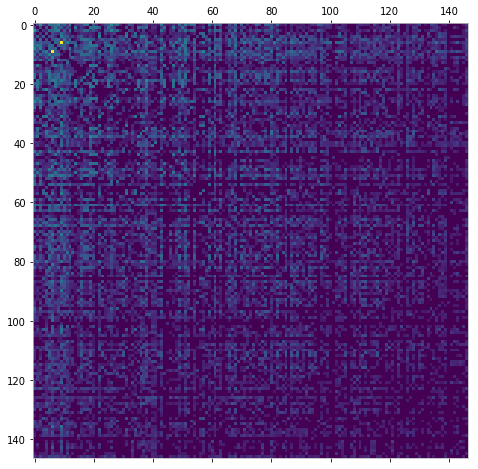

In [11]:
# Two point function

power = .3

twopoint_function = np.zeros((N,N))

for Rx in range(R_Nx):
    for Ry in range(R_Ny):
        s = braggpeak_labels[Rx][Ry]
        perms = permutations(s,2)
        for perm in perms:
            twopoint_function[perm[0],perm[1]] += 1
twopoint_function /= R_Nx*R_Ny

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(twopoint_function**power,cmap='viridis')
ax.grid(False)
plt.show()

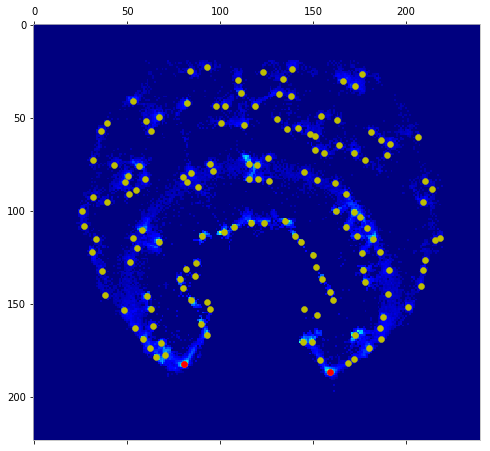

In [12]:
# Find the most correlated pair of Bragg peaks

nmax1,nmax2 = np.unravel_index(np.argmax(twopoint_function),(N,N))

# Show
fig,ax=plt.subplots(figsize=(8,8))
ax.matshow(deconvolution**power,cmap='jet')
ax.scatter(maxima_y,maxima_x,color='y')
ax.scatter(maxima_y[nmax1],maxima_x[nmax1],color='r')
ax.scatter(maxima_y[nmax2],maxima_x[nmax2],color='r')
ax.grid(False)
plt.show()

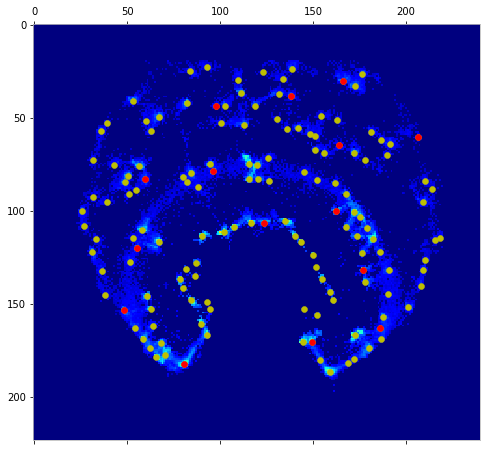

In [177]:
index = 7

class_BP_set = class_BP_sets[index]

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(deconvolution**power,cmap='jet')
ax.scatter(maxima_y,maxima_x,color='y')
for i in class_BP_set:
    ax.scatter(maxima_y[i],maxima_x[i],color='r')
ax.grid(False)
plt.show()

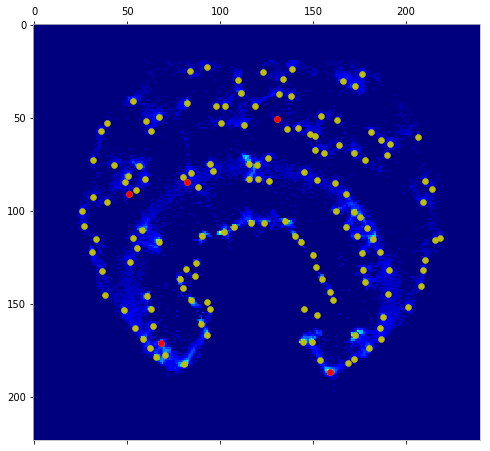

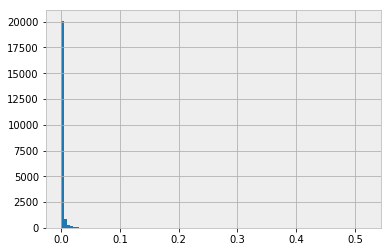

In [61]:
# Find two point function elements which are large and infrequent
# First get histogram of frequencies

nbins = 100

bins = np.linspace(0,np.max(twopoint_function),nbins)
hist,bin_edges = np.histogram(twopoint_function.ravel(),bins=bins)
bin_width = bin_edges[1]-bin_edges[0]

fig,ax = plt.subplots()
ax.bar(bin_edges[:-1]+bin_width/2.,hist,bin_width,align='center')
plt.show()

In [ ]:
# Now get a scoring function

score = np.zeros_like(hist)

In [55]:
ax.bar

In [ ]:
norm = twopoint_function/np.max(twopoint_function)
score = np.where()

fig,ax = plt.suplots()
ax.hist()

In [ ]:
hist = np.histogram

In [14]:
# Three point function

power = 0.3

threepoint_function = np.zeros((N,N,N))

for Rx in range(R_Nx):
    for Ry in range(R_Ny):
        s = braggpeak_labels[Rx][Ry]
        perms = permutations(s,3)
        for perm in perms:
            twopoint_function[perm[0],perm[1]] += 1
twopoint_function /= R_Nx*R_Ny

fig,ax = plt.subplots()
ax.hist(twopoint_function.ravel(),np.linspace(0,.03,100))
plt.show()

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(twopoint_function**power,cmap='jet')
plt.show()

In [11]:
# Parameters

thresh_meanNNint = 3
V = 2
thresh = 0.05

# Bookkeeping
N_classes = 0
labelled = np.zeros((R_Nx,R_Ny),dtype=bool)   # True for scan positions which have been placed in a class

In [ ]:
# Get background

background = mean_NN_intersections < thresh_meanNNint

fig,ax=plt.subplots(figsize=(12,6))
ax.matshow(background)
ax.axis('off')
plt.show()